In [1]:
import cv2
import matplotlib.pyplot as plt
import os

image_dir = './images'  
images = ['img1.jpg', 'img2.jpg', 'img3.jpg']  # 이미지 파일 이름 리스트

# 디렉토리 내 이미지 경로 생성
image_paths = [os.path.join(image_dir, img) for img in images]

# 이미지 경로 출력 (디버깅 용도)
print("Image Paths:", image_paths)


Image Paths: ['./images\\img1.jpg', './images\\img2.jpg', './images\\img3.jpg']


In [2]:
# SIFT 객체 생성
sift = cv2.SIFT_create()

# 키포인트 및 디스크립터 저장 리스트
keypoints_list, descriptors_list = [], []

# 각 이미지에서 SIFT 키포인트와 디스크립터 추출
for img_path in image_paths:
    # 이미지 로드
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # 파일 읽기 확인
    if img is None:
        print(f"Error: Could not load image at path {img_path}")
        continue
    
    # SIFT 키포인트와 디스크립터 계산
    kp, des = sift.detectAndCompute(img, None)
    
    # 결과 저장
    keypoints_list.append(kp)
    descriptors_list.append(des)

    # 디버깅 출력
    print(f"Processed image: {img_path} with {len(kp)} keypoints")

    # 키포인트를 그린 이미지 저장
    img_with_keypoints = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    output_path = os.path.join(image_dir, f'output_{os.path.basename(img_path)}')
    cv2.imwrite(output_path, img_with_keypoints)
    print(f"Keypoints image saved at: {output_path}")


Processed image: ./images\img1.jpg with 7082 keypoints
Keypoints image saved at: ./images\output_img1.jpg
Processed image: ./images\img2.jpg with 7057 keypoints
Keypoints image saved at: ./images\output_img2.jpg
Processed image: ./images\img3.jpg with 8816 keypoints
Keypoints image saved at: ./images\output_img3.jpg


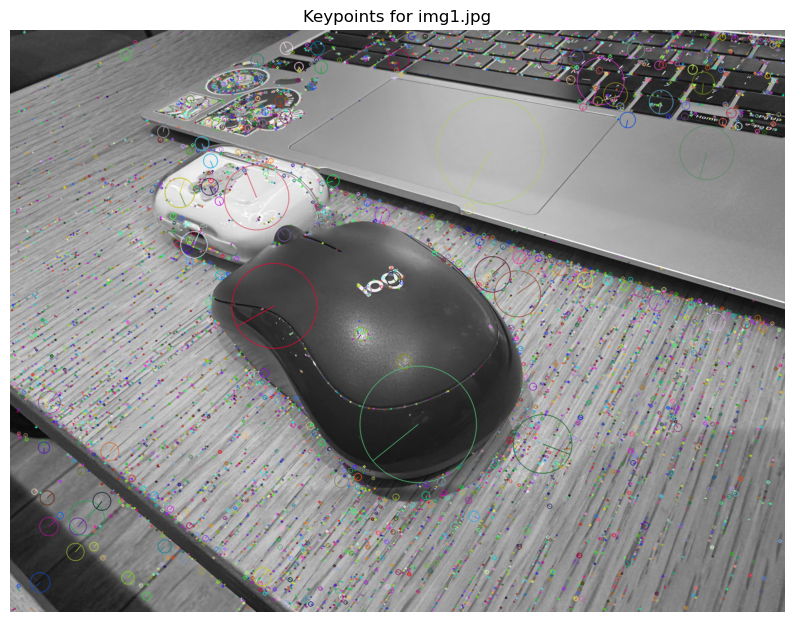

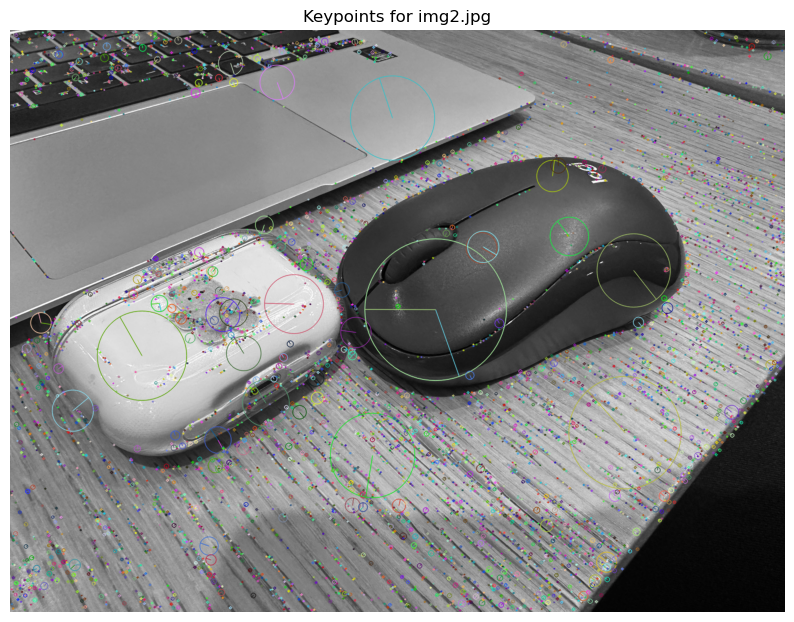

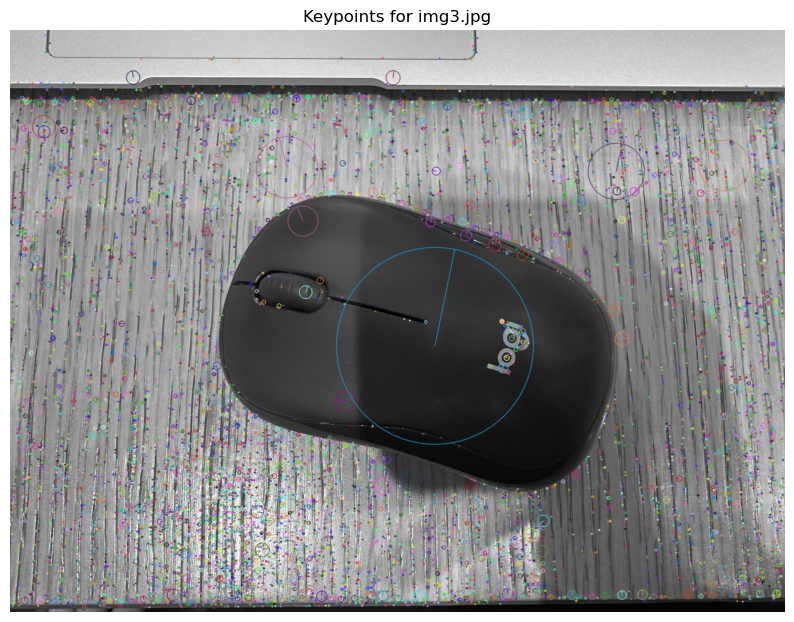

In [3]:
# 키포인트 시각화
for img_path, kp in zip(image_paths, keypoints_list):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_with_keypoints = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # 시각화
    plt.figure(figsize=(10, 10))
    plt.title(f"Keypoints for {os.path.basename(img_path)}")
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.axis('off')
    plt.show()


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 시각화 함수 정의
def plot_images(img1, img2, title1="Image 1", title2="Image 2"):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title(title1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title(title2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


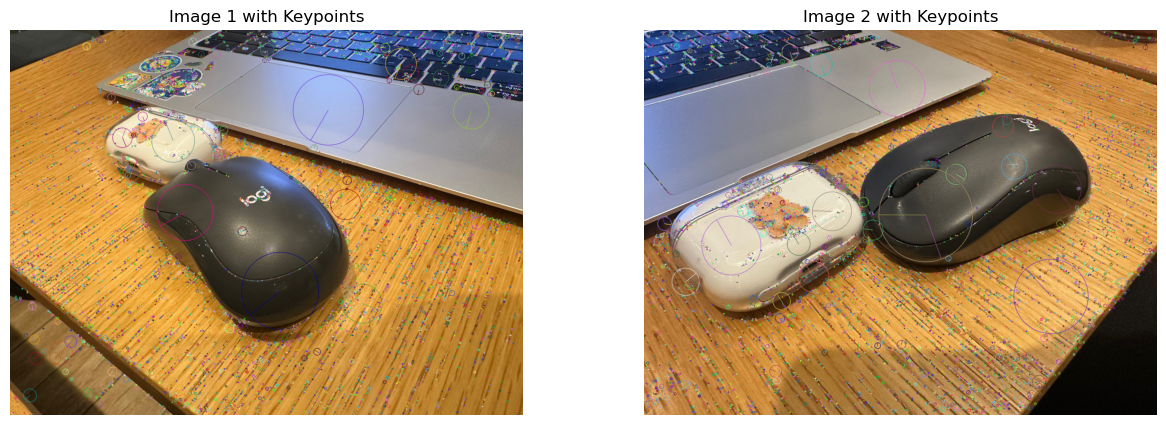

In [5]:
# 두 이미지 로드
img1 = cv2.imread('./images/img1.jpg')
img2 = cv2.imread('./images/img2.jpg')

# 이미지를 흑백으로 변환
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# SIFT 객체 생성 및 키포인트와 디스크립터 계산
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# 키포인트가 감지된 이미지 출력
img1_kp = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# 키포인트 시각화
plot_images(img1_kp, img2_kp, "Image 1 with Keypoints", "Image 2 with Keypoints")


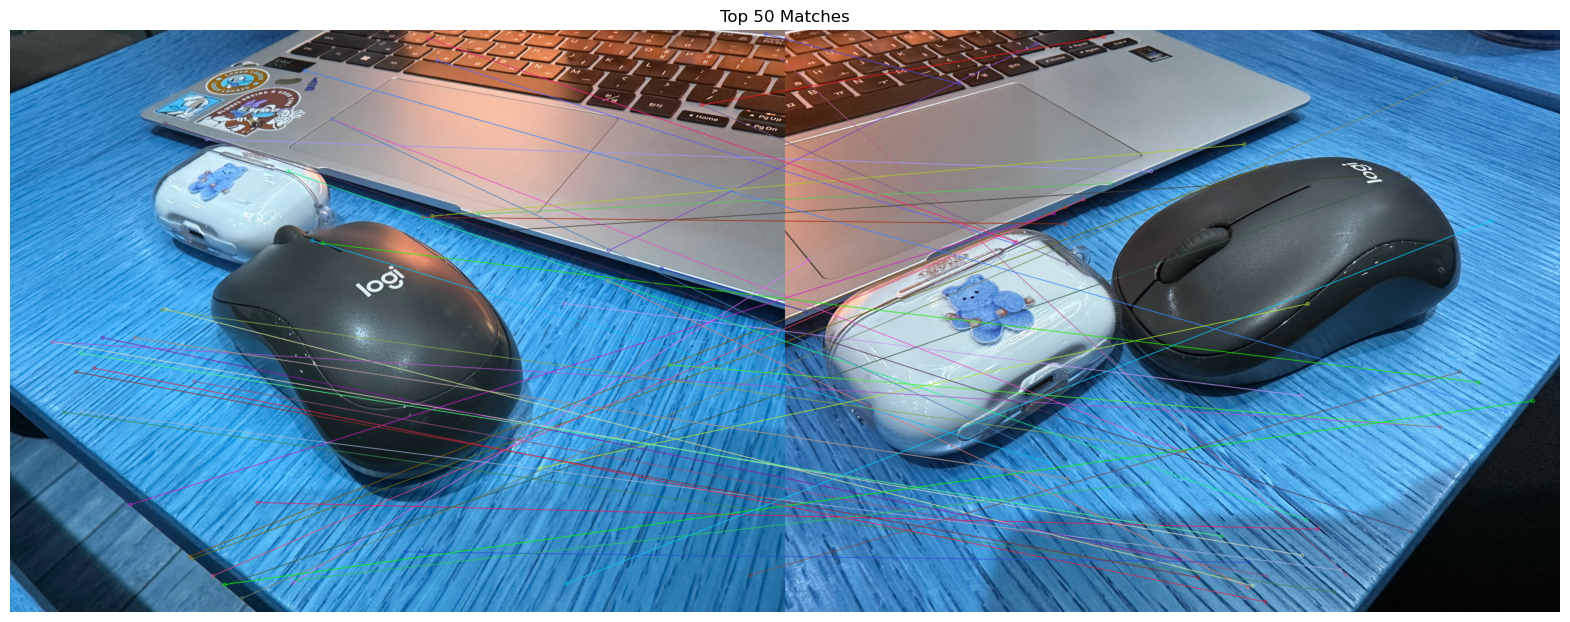

In [6]:
# BFMatcher로 디스크립터 매칭
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

# 매칭 결과를 거리순으로 정렬
matches = sorted(matches, key=lambda x: x.distance)

# 매칭 시각화
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20, 10))
plt.title("Top 50 Matches")
plt.imshow(img_matches)
plt.axis('off')
plt.show()


Estimated Homography Matrix:
 [[ 4.17999799e-01 -1.82456447e+00  1.08566291e+03]
 [ 4.09658596e-01 -1.71853181e+00  1.01610468e+03]
 [ 3.86708577e-04 -1.69126797e-03  1.00000000e+00]]


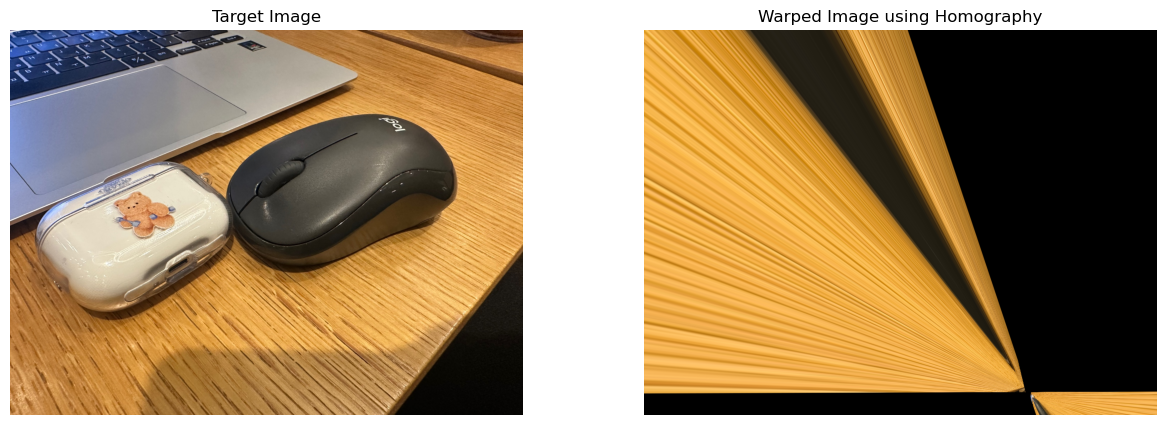

In [7]:
# 매칭된 키포인트 가져오기
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Homography 행렬 계산
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Homography 행렬 출력
print("Estimated Homography Matrix:\n", H)

# 원본 이미지 변환
height, width, channels = img2.shape
warped_img = cv2.warpPerspective(img1, H, (width, height))

# 변환 결과 시각화
plot_images(img2, warped_img, "Target Image", "Warped Image using Homography")


In [8]:
# Homography 행렬로부터 변환 파라미터 추출
def decompose_homography(H):
    H = H / H[2, 2]  # 정규화
    translation = H[:2, 2]  # 이동 벡터
    scale_x = np.linalg.norm(H[0, :2])  # X축 스케일
    scale_y = np.linalg.norm(H[1, :2])  # Y축 스케일
    rotation_angle = np.arctan2(H[1, 0], H[0, 0]) * (180 / np.pi)  # 회전 (도)
    return translation, scale_x, scale_y, rotation_angle

translation, scale_x, scale_y, rotation_angle = decompose_homography(H)
print(f"Translation: {translation}")
print(f"Scale X: {scale_x}, Scale Y: {scale_y}")
print(f"Rotation Angle: {rotation_angle}°")


Translation: [1085.66291139 1016.10468151]
Scale X: 1.8718331521225362, Scale Y: 1.7666838284096678
Rotation Angle: 44.422588437497346°


In [9]:
# 키포인트 좌표 추출
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# 인위적으로 이상치 추가 (잡음을 추가하여 좌표 왜곡)
num_outliers = 10  # 추가할 이상치 개수
np.random.seed(42)  # 결과 재현성을 위해 시드 고정

# 랜덤 좌표 추가 (이상치)
outlier_src = np.random.uniform(0, img1.shape[1], size=(num_outliers, 1, 2))
outlier_dst = np.random.uniform(0, img2.shape[1], size=(num_outliers, 1, 2))

# 기존 점에 이상치 결합
src_pts_with_outliers = np.vstack([src_pts, outlier_src])
dst_pts_with_outliers = np.vstack([dst_pts, outlier_dst])

# 출력 확인
print(f"Original points: {src_pts.shape[0]}, With outliers: {src_pts_with_outliers.shape[0]}")


Original points: 1332, With outliers: 1342


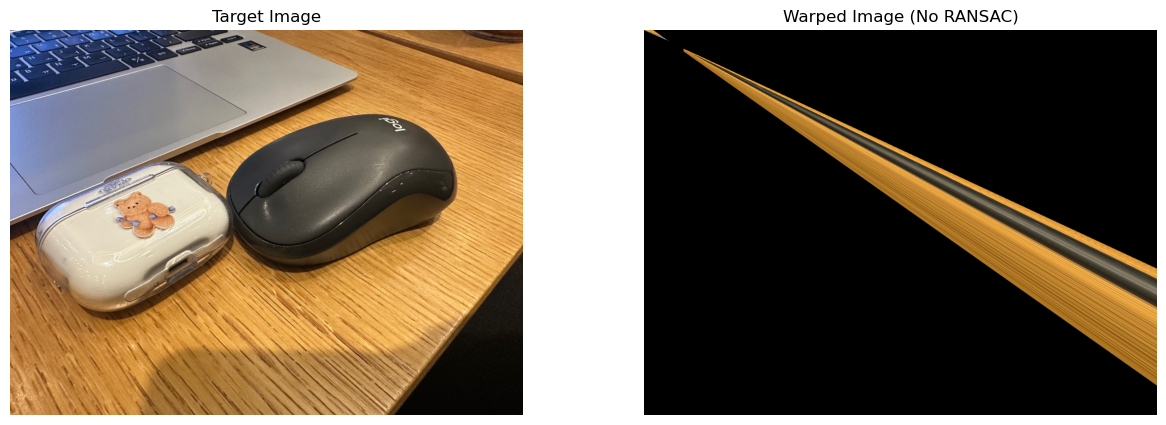

In [10]:
# RANSAC 없이 Homography 계산
H_no_ransac, _ = cv2.findHomography(src_pts_with_outliers, dst_pts_with_outliers, method=0)

# 이미지 변환
warped_no_ransac = cv2.warpPerspective(img1, H_no_ransac, (img2.shape[1], img2.shape[0]))

# 결과 시각화
plot_images(img2, warped_no_ransac, "Target Image", "Warped Image (No RANSAC)")


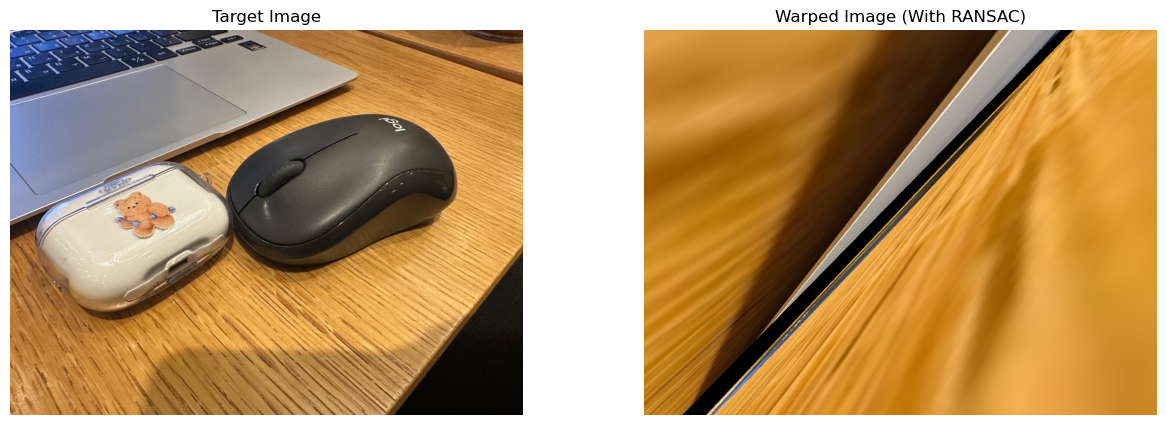

In [11]:
# RANSAC으로 Homography 계산
H_ransac, mask_ransac = cv2.findHomography(src_pts_with_outliers, dst_pts_with_outliers, cv2.RANSAC, 5.0)

# 이미지 변환
warped_with_ransac = cv2.warpPerspective(img1, H_ransac, (img2.shape[1], img2.shape[0]))

# 결과 시각화
plot_images(img2, warped_with_ransac, "Target Image", "Warped Image (With RANSAC)")


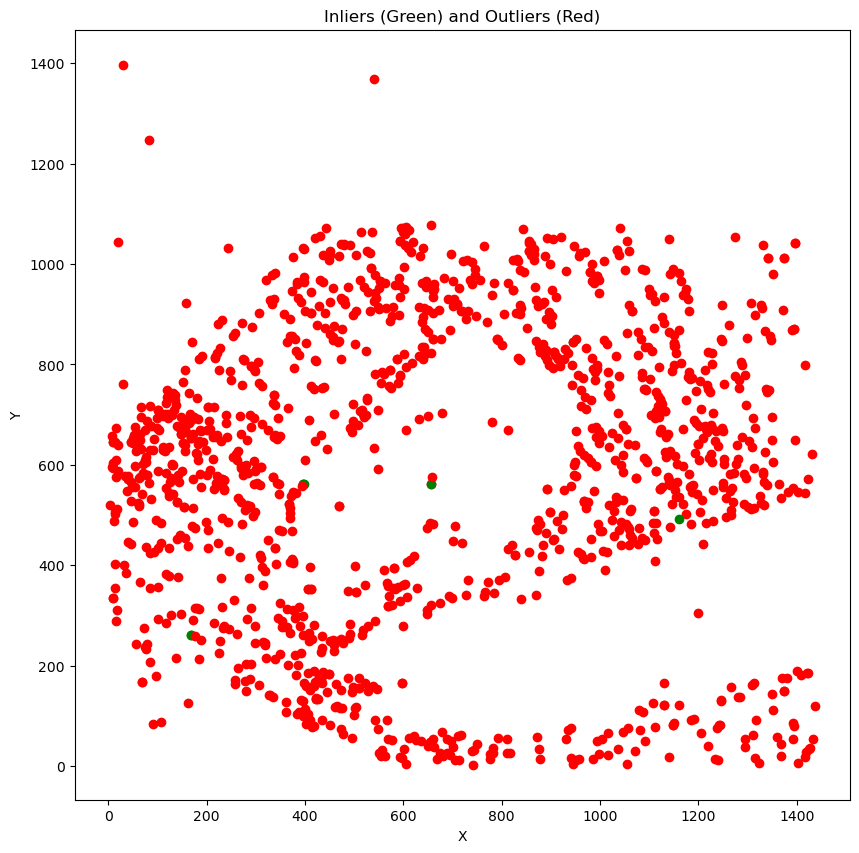

In [12]:
# Inlier와 Outlier 분리
inliers = mask_ransac.ravel().tolist()
outliers = [i for i, m in enumerate(inliers) if not m]

# Inlier 점 시각화
plt.figure(figsize=(10, 10))
for i in range(len(inliers)):
    color = 'green' if inliers[i] else 'red'
    plt.scatter(src_pts_with_outliers[i][0][0], src_pts_with_outliers[i][0][1], c=color)

plt.title("Inliers (Green) and Outliers (Red)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
